# preparations

## install Qiskit

In [27]:
%pip install qiskit qiskit_aer

## loading libraries

In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator

import numpy as np
from scipy.special import eval_chebyt as Chebyshev

import matplotlib.pyplot as plt

from timeit import default_timer as timer
from io import StringIO

import networkx as nx

## Grover parameter optimizers

In [3]:
# delta, Lambda must be in (0, 1)
def GroverQueryComplexity(delta: float, Lambda: float):
    return int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2

# Lambda must be in (0, 1)
def GroverProbability(delta: float, Lambda: float):
    L = 2 * GroverQueryComplexity(delta, Lambda) + 1
    return 1 - np.power(delta * Chebyshev(L, Chebyshev(1 / L, 1 / delta) * np.sqrt(1 - Lambda)), 2)

# Lambda must be in (0, 1), l, N must be positive integers
def GroverParameterOptimizerForComplexity(l: int, Lambda: float, N: int):
    deltas = np.where(np.int8(np.ceil(np.arccosh(1 / np.linspace(1 - np.exp2(- N), np.exp2(- N), 1 << N)) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2 <= l, np.linspace(1 - np.exp2(- N), np.exp2(- N), 1 << N), 0)
    prob = GroverProbability(deltas[0], Lambda)
    for d in deltas[1: np.where(deltas == 0)[0][0]]:
        if GroverProbability(d, Lambda) > prob:
            delta, prob = d, GroverProbability(d, Lambda)

    return delta

## fan-out gates

In [4]:
def FanOut(digits: int):

    # misc definitions
    b = int(np.floor(np.log2(digits)))
    jumps = 1 << np.arange(b)
    bits = (digits >> np.arange(b))%2



    # circuit
    qcontrol = QuantumRegister(1, "x")
    qtarget = QuantumRegister(digits, "y")
    qc = QuantumCircuit(qcontrol, qtarget, name=f"fan-out")



    for jump in jumps:
        for i in range(digits - 2 * jump, - 1, - 2 * jump):
            qc.cx(qtarget[i], qtarget[i + jump])

    for idx in np.where(bits)[0]:
        qc.cx(qtarget[0], qtarget[np.sum(1 << bits[:idx + 1]) - 1])



    qc.cx(qcontrol[0], qtarget[0])



    for idx in reversed(np.where(bits)[0]):
        qc.cx(qtarget[0], qtarget[np.sum(1 << bits[:idx + 1]) - 1])

    for jump in reversed(jumps):
        for i in range(digits - 2 * jump, - 1, - 2 * jump):
            qc.cx(qtarget[i], qtarget[i + jump])



    return qc

In [5]:
FanOut(5).draw()

x: ─────────────────■─────────────────
                    ┌─┴─┐               
y_0: ────────────■──┤ X ├──■────────────
               ┌─┴─┐└───┘┌─┴─┐          
y_1: ──■────■──┤ X ├─────┤ X ├──■────■──
     ┌─┴─┐  │  └───┘     └───┘  │  ┌─┴─┐
y_2: ┤ X ├──┼───────────────────┼──┤ X ├
     └───┘┌─┴─┐               ┌─┴─┐└───┘
y_3: ──■──┤ X ├───────────────┤ X ├──■──
     ┌─┴─┐└───┘               └───┘┌─┴─┐
y_4: ┤ X ├─────────────────────────┤ X ├
     └───┘                         └───┘

In [6]:
def PhaserOracle(QuadraticForm: list[list[int]], digits: int):

    # misc definitions
    b = int(np.floor(np.log2(digits)))
    jumps = 1 << np.arange(b)
    bits = (digits >> np.arange(b))%2

    # we often need these values
    PiOverPowerOfTwo = np.pi / (1 << np.arange(max(QuadraticForm.shape[0], digits)))

    QRegX = QuantumRegister(QuadraticForm.shape[0], "x") # quantum registers for the bit configurations
    QRegY = AncillaRegister(digits, "y") # quantum registers to digitize values

    QC = QuantumCircuit(QRegX, QRegY, name=f"phaser")

    for idx, q in enumerate(QRegX):

        for jump in jumps:
            for i in range(digits - 2 * jump, - 1, - 2 * jump):
                QC.cx(QRegY[i], QRegY[i + jump])

        for i in np.where(bits)[0]:
            QC.cx(QRegY[0], QRegY[np.sum(1 << bits[:i + 1]) - 1])

        QC.cx(q, QRegY[0])

        for i in reversed(np.where(bits)[0]):
            QC.cx(QRegY[0], QRegY[np.sum(1 << bits[:i + 1]) - 1])

        for jump in reversed(jumps):
            for i in range(digits - 2 * jump, - 1, - 2 * jump):
                QC.cx(QRegY[i], QRegY[i + jump])

        qi = np.sum(QuadraticForm[idx]) / 2
        if qi != 0:
            for jdx, p in enumerate(reversed(QRegY)):
                QC.p(qi * PiOverPowerOfTwo[jdx], p)
        for kdx, r in enumerate(QRegX[idx + 1:]):
            Qij = QuadraticForm[idx, idx + 1 + kdx] / 2
            if Qij != 0:
                for jump in jumps:
                    for i in range(digits - 2 * jump, - 1, - 2 * jump):
                        QC.cx(QRegY[i], QRegY[i + jump])

                for i in np.where(bits)[0]:
                    QC.cx(QRegY[0], QRegY[np.sum(1 << bits[:i + 1]) - 1])

                QC.cx(r, QRegY[0])

                for i in reversed(np.where(bits)[0]):
                    QC.cx(QRegY[0], QRegY[np.sum(1 << bits[:i + 1]) - 1])

                for jump in reversed(jumps):
                    for i in range(digits - 2 * jump, - 1, - 2 * jump):
                        QC.cx(QRegY[i], QRegY[i + jump])

                for jdx, p in enumerate(reversed(QRegY)):
                    QC.p(- Qij * PiOverPowerOfTwo[jdx], p)

                for jump in jumps:
                    for i in range(digits - 2 * jump, - 1, - 2 * jump):
                        QC.cx(QRegY[i], QRegY[i + jump])

                for i in np.where(bits)[0]:
                    QC.cx(QRegY[0], QRegY[np.sum(1 << bits[:i + 1]) - 1])

                QC.cx(r, QRegY[0])

                for i in reversed(np.where(bits)[0]):
                    QC.cx(QRegY[0], QRegY[np.sum(1 << bits[:i + 1]) - 1])

                for jump in reversed(jumps):
                    for i in range(digits - 2 * jump, - 1, - 2 * jump):
                        QC.cx(QRegY[i], QRegY[i + jump])

        for jump in jumps:
            for i in range(digits - 2 * jump, - 1, - 2 * jump):
                QC.cx(QRegY[i], QRegY[i + jump])

        for i in np.where(bits)[0]:
            QC.cx(QRegY[0], QRegY[np.sum(1 << bits[:i + 1]) - 1])

        QC.cx(q, QRegY[0])

        for i in reversed(np.where(bits)[0]):
            QC.cx(QRegY[0], QRegY[np.sum(1 << bits[:i + 1]) - 1])

        for jump in reversed(jumps):
            for i in range(digits - 2 * jump, - 1, - 2 * jump):
                QC.cx(QRegY[i], QRegY[i + jump])

    return QC

# Grover Fixed Point Search for integer Quadratic Binary Optimization problems (minimal number of ancillas)

In [7]:
def FPGSForQUBO(QuadraticForm: list[list[int]], digits: int, threshold: int, l: int, delta: float):

    GroverPhases = 2 * np.arctan(1 / (np.tanh(np.arccosh(1 / delta) / (2 * l + 1)) * np.tan(np.arange(1, l + 1) * 2 * np.pi / (2 * l + 1))))

    # we often need these values
    PiOverPowerOfTwo = np.pi / (1 << np.arange(max(QuadraticForm.shape[0], digits)))

    # circuit preparation
    QRegX = QuantumRegister(QuadraticForm.shape[0], "x") # quantum registers for the bit configurations
    QRegY = AncillaRegister(digits, "y") # quantum registers to digitize values

    QC = QuantumCircuit(QRegX, QRegY, name=f"Fixed-point Grover Search Circuit")

    PO = PhaserOracle(QuadraticForm, digits).to_gate()
    UPO = PO.inverse()
    UPO.label = f"unphaser"

    # state-preparation
    QC.h(QRegX)
    # QFT without the SWAPs
    for i, q in enumerate(QRegY):
        QC.h(q)
        for j, r in enumerate(QRegY[i + 1:]):
            QC.cp(PiOverPowerOfTwo[j + 1], q, r)

    # adding threshold
    for idx, q in enumerate(reversed(QRegY)):
        QC.p((threshold - 1 - (np.trace(QuadraticForm) + np.sum(QuadraticForm)) / 4) * PiOverPowerOfTwo[idx], q)

    # Fixed-point Grover Search bang-bangs
    for alpha, beta in zip(GroverPhases, reversed(GroverPhases)):

        # S_t (beta)
        # subtracting from ancillas
        QC.append(PO, QRegX[:] + QRegY[:])

        # inverse QFT without the SWAPs
        for i, q in enumerate(reversed(QRegY)):
            QC.h(q)
            for j, r in enumerate(reversed(QRegY[:- i - 1])):
                QC.cp(- PiOverPowerOfTwo[j + 1], q, r)

        QC.p(beta, QRegY[0])

        # QFT without the SWAPs
        for i, q in enumerate(QRegY):
            QC.h(q)
            for j, r in enumerate(QRegY[i + 1:]):
                QC.cp(PiOverPowerOfTwo[j + 1], q, r)

        # adding back to ancillas
        QC.append(UPO, QRegX[:] + QRegY[:])

        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        QC.mcp(alpha, QRegX[:- 1], QRegX[- 1])
        QC.x(QRegX)
        QC.h(QRegX)

    return QC

# parameters & testing for MaxCut:

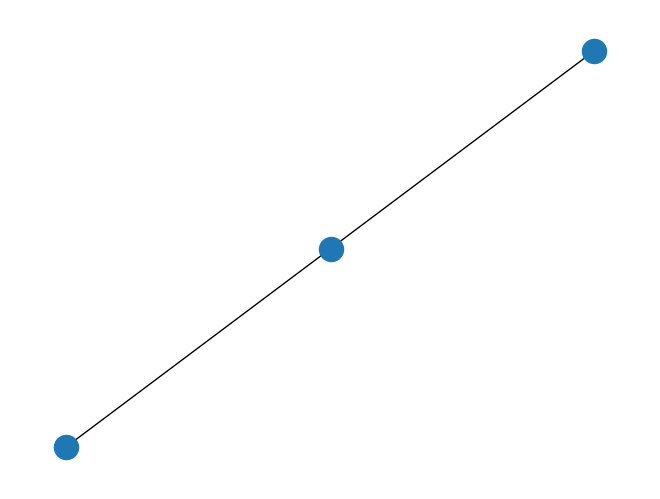

In [8]:
# random, connected graph
NumberOfVertices, EdgeProbability = 3, 5e-1
Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
while not nx.is_connected(Graph):
    Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
nx.draw(Graph, with_labels=False)

In [9]:
GraphLaplacian = nx.laplacian_matrix(Graph).toarray()
NumberOfEdges = np.trace(GraphLaplacian) // 2
threshold = int(np.ceil((2 * NumberOfEdges + NumberOfVertices - 1)/4))
digits = int(np.ceil(np.log2(threshold + 1))) + 1 if NumberOfVertices > 2 else 1 # number of ancilla qubits needed to digitize cuts

# let's get rid of the vertex with the highest degree; this step is not necessary, but saves one qubit
maxdegvertex = np.where(np.diag(GraphLaplacian) == np.max(np.diag(GraphLaplacian)))[0][0]
if maxdegvertex + 1 != NumberOfVertices:
    GraphLaplacian[[maxdegvertex, -1], :] = GraphLaplacian[[-1, maxdegvertex], :]
    GraphLaplacian[:, [maxdegvertex, -1]] = GraphLaplacian[:, [-1, maxdegvertex]]
QuadraticForm = GraphLaplacian[np.ix_(np.arange(NumberOfVertices - 1), np.arange(NumberOfVertices - 1))]

# classical, brute-force cut-function and MaxCut computation
cuts = np.empty(1 << QuadraticForm.shape[0], dtype=int)
for x, _ in enumerate(cuts):
    conf = (x >> np.arange(QuadraticForm.shape[0]))&1
    cuts[x] = np.inner(conf@QuadraticForm, conf)
MaxCut = np.max(cuts)

# cut statistics
RandomChance, Lambda, m, sigma = np.array([np.sum(np.where(cuts == cut, 1, 0)) for cut in range(MaxCut + 1)]) * np.exp2(1 - NumberOfVertices), np.sum(np.where(cuts >= threshold, 1, 0)) * np.exp2(1 - NumberOfVertices), NumberOfEdges / 2, np.std(cuts)

In [10]:
l = 1
delta = GroverParameterOptimizerForComplexity(l, Lambda, 10)
TargetProbability = GroverProbability(delta, Lambda)

print(f"MaxCut\tthreshold\tLambda\ttarget probability\tdelta\tl\tdigits\n{MaxCut}\t{threshold}\t\t{Lambda:.2f}\t{TargetProbability:.2%}\t\t\t{delta:.2}\t{l}\t{digits}\n")

MaxCut	threshold	Lambda	target probability	delta	l	digits
2	2		0.25	99.39%			0.87	1	3



### simulation and evaluation of data:

In [11]:
print(f"\ncomputation with the Grover Fixed-Point Search...\n")
Start = timer()

QC = FPGSForQUBO(QuadraticForm, digits, threshold, l, delta)

print(f"done in {(timer() - Start):.2f} seconds\n")


computation with Grover Fixed-Point Search...

done in 0.00 seconds



In [20]:
probabilities = Statevector(QC).probabilities(np.arange(QC.num_qubits - QC.num_ancillas))
distribution = np.array([np.sum(np.where(cuts == cut, probabilities, 0)) for cut in range(MaxCut + 1)])
SuccessProbability = np.sum(distribution[threshold:])
M = np.dot(distribution, np.arange(distribution.shape[0]))
var = np.sqrt(np.dot(distribution, np.arange(distribution.shape[0])**2) - M**2)
sign_m, sign_sigma = "+" if M >= m else "-", "+" if var >= sigma else "-"

In [21]:
ss = StringIO(f"")
ss.write(f"\nthe graph:\n----------\nMaxCut\t\t\t\t= {MaxCut}\nnumber of edges\t\t\t= {NumberOfEdges}\n")
ss.write(f"threshold (Erdős-Edwards bound)\t= {threshold} ({threshold/MaxCut:.1%} of MaxCut)")
ss.write(f"\n\nthe graph Laplacian:\n--------------------\n\n" + f"".join([f"{row.view()}\n" for row in GraphLaplacian]))
ss.write(f"\nGrover parameters:\n------------------\nLambda\t\t\t= {Lambda:.2f}\ndelta\t\t\t= {delta:.2f}")
ss.write(f"\nquery complexity\t= {l}\n\nresults with Grover:\n--------------------\n\n")
ss.write(f"success probability\t= {SuccessProbability:.1%} (theoretical value = {TargetProbability:.1%}, random chance = {Lambda:.1%})\n")
ss.write(f"expectation\t\t= {M:.1f}\t({m} {sign_m} {abs(M - m):.1f})\n")
ss.write(f"variance\t\t= {var:.1f}\t({sigma:.1f} {sign_sigma} {abs(var - sigma):.1f})\n\n")
#ss.write(f"CNOT count\t\t= {QC.count_ops()['cx']}\ncircuit depth\t\t= {QC.depth()}") # since we're using complex, built-in gates, like MCP, this is meaningless right now
print(ss.getvalue())


the graph:
----------
MaxCut				= 2
number of edges			= 2
threshold (Erdős-Edwards bound)	= 2 (100.0% of MaxCut)

the graph Laplacian:
--------------------

[ 1  0 -1]
[ 0  1 -1]
[-1 -1  2]

Grover parameters:
------------------
Lambda			= 0.25
delta			= 0.87
query complexity	= 1

results with Grover:
--------------------

success probability	= 99.4% (theoretical value = 99.4%, random chance = 25.0%)
expectation		= 2.0	(1.0 + 1.0)
variance		= 0.1	(0.7 - 0.6)




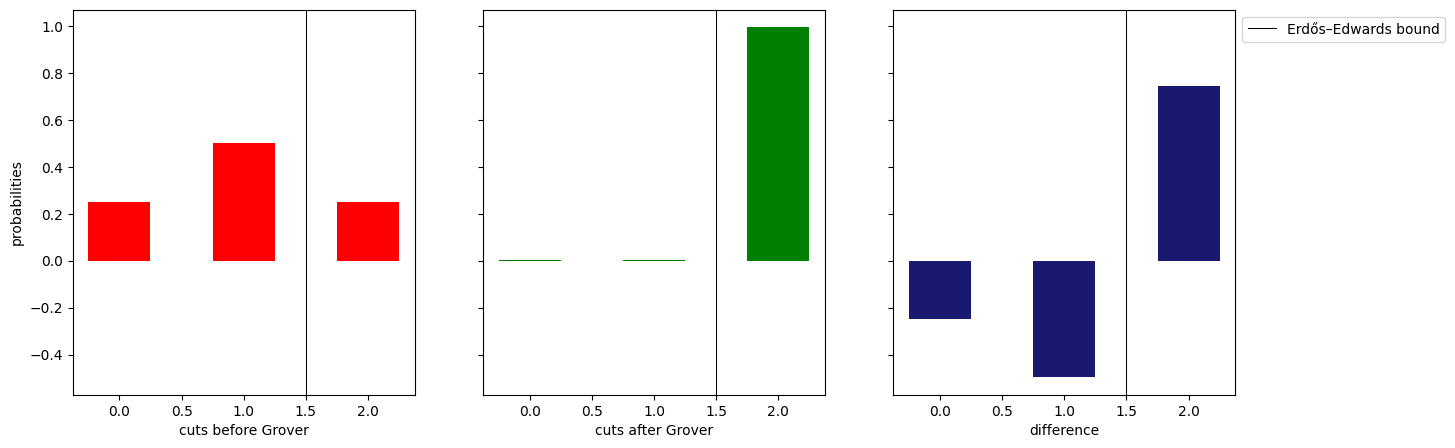

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

axs[0].bar(np.arange(RandomChance.shape[0]),
           RandomChance,
           width=0.5,
           color="red")
axs[0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")
axs[0].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black")

axs[1].bar(np.arange(distribution.shape[0]),
           distribution,
           width=0.5,
           color="green")
axs[1].set(xlabel=f"cuts after Grover")
axs[1].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black")

axs[2].bar(np.arange(distribution.shape[0]),
           distribution - RandomChance,
           width=0.5,
           color="midnightblue")
axs[2].set(xlabel=f"difference")
axs[2].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black",
               label=f"Erdős–Edwards bound")

plt.legend(bbox_to_anchor = (1.0, 1), loc = "upper left")

plt.show()

# Grover Fixed Point Search for integer Quadratic Binary Optimization problems (maximal number of ancillas)

In [15]:
def ExtendedPhaserOracle(QuadraticForm: list[list[int]], digits: int):

    # we often need these values
    PiOverPowerOfTwo = np.pi / (1 << np.arange(max(QuadraticForm.shape[0], digits + 1)))

    n = QuadraticForm.shape[0]
    m = (n**2 + n) // 2 + 1

    Phases = np.zeros(m)
    Phases[0] = (threshold - 1 - (np.trace(QuadraticForm) + np.sum(QuadraticForm)) / 4)
    loc = 1
    for idx, row in enumerate(QuadraticForm):
        Phases[loc], Phases[loc + 1:loc + n - idx] = np.sum(row), - row[idx + 1:]
        loc += n - idx

    # circuit preparation
    QRegX = QuantumRegister(QuadraticForm.shape[0], "x") # quantum registers for the bit configurations
    QRegY = AncillaRegister(m * digits, "y") # quantum registers to digitize values

    QC = QuantumCircuit(QRegX, QRegY, name=f"Fixed-point Grover Search Circuit")

    # state-preparation
    FOm = FanOut(m - 1).to_gate()
    for idx, q in enumerate(QRegY[:digits]):
        QC.append(FOm, [q] + QRegY[idx + digits::digits])
    # this part could be a bit more balanced on the data qubits, but it's still optimal in the big-O sense
    end = digits
    for idx, q in enumerate(QRegX):
        start = end
        end += (n - idx) * digits
        FO = FanOut(end - start).to_gate()
        QC.append(FO, [q] + QRegY[start:end])

    # adding phases
    for idx, phase in enumerate(Phases):
        for jdx, q in enumerate(reversed(QRegY[idx * digits:(idx + 1) * digits])):
            QC.p(phase * PiOverPowerOfTwo[jdx], q)

    # fan-outs are idempotent and commute with phases, so the same instructions work
    end = digits
    for idx, q in enumerate(QRegX):
        start = end
        end += (n - idx) * digits
        FO = FanOut(end - start).to_gate()
        QC.append(FO, [q] + QRegY[start:end])

    for idx, q in enumerate(QRegY[:digits]):
        QC.append(FOm, [q] + QRegY[idx + digits::digits])

    return QC

In [18]:
def ExtendedFPGSForQUBO(QuadraticForm: list[list[int]], digits: int, threshold: int, l: int, delta: float):

    GroverPhases = 2 * np.arctan(1 / (np.tanh(np.arccosh(1 / delta) / (2 * l + 1)) * np.tan(np.arange(1, l + 1) * 2 * np.pi / (2 * l + 1))))

    n = QuadraticForm.shape[0]
    m = (n**2 + n) // 2 + 1

    # circuit preparation
    QRegX = QuantumRegister(QuadraticForm.shape[0], "x") # quantum registers for the bit configurations
    QRegY = AncillaRegister(m * digits, "y") # quantum registers to digitize values

    QC = QuantumCircuit(QRegX, QRegY, name=f"Extended Fixed-point Grover Search Circuit")

    PO = ExtendedPhaserOracle(QuadraticForm, digits).to_gate()
    UPO = PO.inverse()
    UPO.label = f"unphaser"

    # we often need these values
    PiOverPowerOfTwo = np.pi / (1 << np.arange(max(n, digits + 1)))

    # state-preparation
    QC.h(QRegX)
    # QFT without the SWAPs
    for i, q in enumerate(QRegY[:digits]):
        QC.h(q)
        for j, r in enumerate(QRegY[i + 1:digits]):
            QC.cp(PiOverPowerOfTwo[j + 1], q, r)

    # Fixed-point Grover Search bang-bangs
    for alpha, beta in zip(GroverPhases, reversed(GroverPhases)):

        # S_t (beta)
        # subtracting from ancillas
        QC.append(PO, QRegX[:] + QRegY[:])

        # inverse QFT without the SWAPs
        for i, q in enumerate(reversed(QRegY[:digits])):
            QC.h(q)
            for j, r in enumerate(reversed(QRegY[:digits - 1 - i])):
                QC.cp(- PiOverPowerOfTwo[j + 1], q, r)

        QC.p(beta, QRegY[0])

        # QFT without the SWAPs
        for i, q in enumerate(QRegY[:digits]):
            QC.h(q)
            for j, r in enumerate(QRegY[i + 1:digits]):
                QC.cp(PiOverPowerOfTwo[j + 1], q, r)

        # adding back to ancillas
        QC.append(UPO, QRegX[:] + QRegY[:])

        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        QC.mcp(alpha, QRegX[:- 1], QRegX[- 1])
        QC.x(QRegX)
        QC.h(QRegX)

    return QC

In [19]:
print(f"\ncomputation with the Extended Grover Fixed-Point Search...\n")
Start = timer()

#QC = FPGSForQUBO(QuadraticForm, digits, threshold, l, delta)
QC = ExtendedFPGSForQUBO(QuadraticForm, digits, threshold, l, delta)

print(f"done in {(timer() - Start):.2f} seconds\n")


computation with Grover Fixed-Point Search...

done in 0.00 seconds



In [23]:
probabilities = Statevector(QC).probabilities(np.arange(QC.num_qubits - QC.num_ancillas))
distribution = np.array([np.sum(np.where(cuts == cut, probabilities, 0)) for cut in range(MaxCut + 1)])
SuccessProbability = np.sum(distribution[threshold:])
M = np.dot(distribution, np.arange(distribution.shape[0]))
var = np.sqrt(np.dot(distribution, np.arange(distribution.shape[0])**2) - M**2)
sign_m, sign_sigma = "+" if M >= m else "-", "+" if var >= sigma else "-"

In [24]:
ss = StringIO(f"")
ss.write(f"\nthe graph:\n----------\nMaxCut\t\t\t\t= {MaxCut}\nnumber of edges\t\t\t= {NumberOfEdges}\n")
ss.write(f"threshold (Erdős-Edwards bound)\t= {threshold} ({threshold/MaxCut:.1%} of MaxCut)")
ss.write(f"\n\nthe graph Laplacian:\n--------------------\n\n" + f"".join([f"{row.view()}\n" for row in GraphLaplacian]))
ss.write(f"\nGrover parameters:\n------------------\nLambda\t\t\t= {Lambda:.2f}\ndelta\t\t\t= {delta:.2f}")
ss.write(f"\nquery complexity\t= {l}\n\nresults with Grover:\n--------------------\n\n")
ss.write(f"success probability\t= {SuccessProbability:.1%} (theoretical value = {TargetProbability:.1%}, random chance = {Lambda:.1%})\n")
ss.write(f"expectation\t\t= {M:.1f}\t({m} {sign_m} {abs(M - m):.1f})\n")
ss.write(f"variance\t\t= {var:.1f}\t({sigma:.1f} {sign_sigma} {abs(var - sigma):.1f})\n\n")
#ss.write(f"CNOT count\t\t= {QC.count_ops()['cx']}\ncircuit depth\t\t= {QC.depth()}") # since we're using complex, built-in gates, like MCP, this is meaningless right now
print(ss.getvalue())


the graph:
----------
MaxCut				= 2
number of edges			= 2
threshold (Erdős-Edwards bound)	= 2 (100.0% of MaxCut)

the graph Laplacian:
--------------------

[ 1  0 -1]
[ 0  1 -1]
[-1 -1  2]

Grover parameters:
------------------
Lambda			= 0.25
delta			= 0.87
query complexity	= 1

results with Grover:
--------------------

success probability	= 99.4% (theoretical value = 99.4%, random chance = 25.0%)
expectation		= 2.0	(1.0 + 1.0)
variance		= 0.1	(0.7 - 0.6)




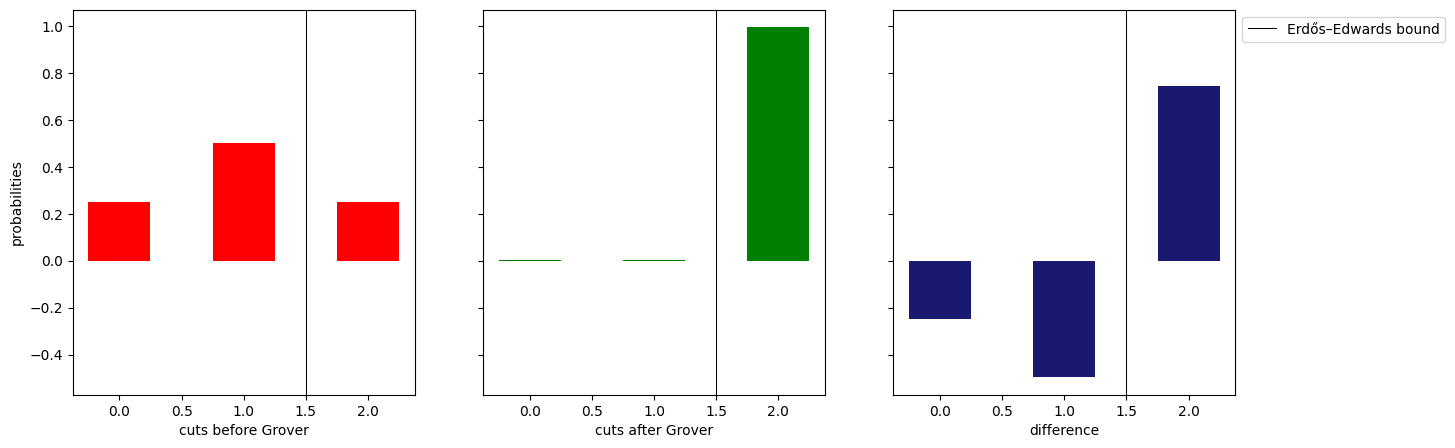

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

axs[0].bar(np.arange(RandomChance.shape[0]),
           RandomChance,
           width=0.5,
           color="red")
axs[0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")
axs[0].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black")

axs[1].bar(np.arange(distribution.shape[0]),
           distribution,
           width=0.5,
           color="green")
axs[1].set(xlabel=f"cuts after Grover")
axs[1].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black")

axs[2].bar(np.arange(distribution.shape[0]),
           distribution - RandomChance,
           width=0.5,
           color="midnightblue")
axs[2].set(xlabel=f"difference")
axs[2].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black",
               label=f"Erdős–Edwards bound")

plt.legend(bbox_to_anchor = (1.0, 1), loc = "upper left")

plt.show()

In [27]:
ExtendedPhaserOracle(QuadraticForm, digits).draw()

┌──────────┐                      »
 x_0: ────────────────────────────────────┤0         ├──────────────────────»
                                          │          │┌──────────┐          »
 x_1: ────────────────────────────────────┤          ├┤0         ├──────────»
      ┌──────────┐  ┌──────┐              │          ││          │          »
 y_0: ┤0         ├──┤ P(0) ├──────────────┤          ├┤          ├──────────»
      │          │┌─┴──────┴─┐  ┌──────┐  │          ││          │          »
 y_1: ┤          ├┤0         ├──┤ P(0) ├──┤          ├┤          ├──────────»
      │          ││          │┌─┴──────┴─┐│          ││          │ ┌──────┐ »
 y_2: ┤          ├┤          ├┤0         ├┤          ├┤          ├─┤ P(0) ├─»
      │          ││          ││          ││          ││          │┌┴──────┴┐»
 y_3: ┤1         ├┤          ├┤          ├┤1 fan-out ├┤          ├┤ P(π/4) ├»
      │          ││          ││          ││          ││          │├────────┤»
 y_4: ┤          ├┤1         ├┤          ├┤2         ├┤          ├┤ P(π/2) ├»
      │  fan-out ││          ││          ││          ││          │└┬──────┬┘»
 y_5: ┤          ├┤          ├┤1         ├┤3         ├┤  fan-out ├─┤ P(π) ├─»
      │          ││  fan-out ││          ││          ││          │ ├──────┤ »
 y_6: ┤2         ├┤          ├┤          ├┤4         ├┤          ├─┤ P(0) ├─»
      │          ││          ││  fan-out ││          ││          │ ├──────┤ »
 y_7: ┤          ├┤2         ├┤          ├┤5         ├┤          ├─┤ P(0) ├─»
      │          ││          ││          ││          ││          │ ├──────┤ »
 y_8: ┤          ├┤          ├┤2         ├┤6         ├┤          ├─┤ P(0) ├─»
      │          ││          ││          │└──────────┘│          │┌┴──────┴┐»
 y_9: ┤3         ├┤          ├┤          ├────────────┤1         ├┤ P(π/4) ├»
      └──────────┘│          ││          │            │          │├────────┤»
y_10: ────────────┤3         ├┤          ├────────────┤2         ├┤ P(π/2) ├»
                  └──────────┘│          │            │          │└┬──────┬┘»
y_11: ────────────────────────┤3         ├────────────┤3         ├─┤ P(π) ├─»
                              └──────────┘            └──────────┘ └──────┘ »
«      ┌──────────┐                                                
« x_0: ┤0         ├────────────────────────────────────────────────
«      │          │┌──────────┐                                    
« x_1: ┤          ├┤0         ├────────────────────────────────────
«      │          ││          │┌──────────┐                        
« y_0: ┤          ├┤          ├┤0         ├────────────────────────
«      │          ││          ││          │┌──────────┐            
« y_1: ┤          ├┤          ├┤          ├┤0         ├────────────
«      │          ││          ││          ││          │┌──────────┐
« y_2: ┤          ├┤          ├┤          ├┤          ├┤0         ├
«      │          ││          ││          ││          ││          │
« y_3: ┤1 fan-out ├┤          ├┤1         ├┤          ├┤          ├
«      │          ││          ││          ││          ││          │
« y_4: ┤2         ├┤          ├┤          ├┤1         ├┤          ├
«      │          ││          ││  fan-out ││          ││          │
« y_5: ┤3         ├┤  fan-out ├┤          ├┤          ├┤1         ├
«      │          ││          ││          ││  fan-out ││          │
« y_6: ┤4         ├┤          ├┤2         ├┤          ├┤          ├
«      │          ││          ││          ││          ││  fan-out │
« y_7: ┤5         ├┤          ├┤          ├┤2         ├┤          ├
«      │          ││          ││          ││          ││          │
« y_8: ┤6         ├┤          ├┤          ├┤          ├┤2         ├
«      └──────────┘│          ││          ││          ││          │
« y_9: ────────────┤1         ├┤3         ├┤          ├┤          ├
«                  │          │└──────────┘│          ││          │
«y_10: ────────────┤2         ├────────────┤3         ├┤          ├
«           